In [7]:
# multigrid_gnn_multires_physics.py
"""
Physics-informed Multigrid + GNN eigen-refinement
- Exact solve only on coarsest mesh
- Multiresolution GNN with residual + orthonormality + projection loss
- Coarse-to-fine prolongation only
"""

import os
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from Mesh import Mesh
import robust_laplacian

# ------------------------
# Utilities
# ------------------------
def sp_to_torch_sparse(A):
    A = A.tocoo()
    indices = np.vstack((A.row, A.col)).astype(np.int64)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(A.data)
    return torch.sparse_coo_tensor(i, v, A.shape).coalesce()

def normalize_columns_np(U, eps=1e-12):
    norms = np.linalg.norm(U, axis=0) + eps
    return U / norms, norms

def normalize_columns_torch(U, eps=1e-12):
    norms = torch.norm(U, dim=0) + eps
    return U / norms, norms

# ------------------------
# Simple neighbor-mean corrector
# ------------------------
class SimpleCorrector(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_sizes=(128,64,32), dropout=0.0):
        super().__init__()
        layers = []
        prev = in_dim * 2
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, edge_index):
        row, col = edge_index
        n = x.shape[0]
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        deg = torch.bincount(row, minlength=n).unsqueeze(1).to(x.dtype).to(x.device).clamp(min=1.0)
        agg = agg / deg
        h = torch.cat([x, agg], dim=1)
        return self.net(h)

# ------------------------
# Multigrid GNN solver
# ------------------------
class MultigridGNN:
    def __init__(self, device=None, checkpoint_dir="./checkpoints"):
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.model = None
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    @staticmethod
    def normalize_mesh(mesh):
        centroid = mesh.verts.mean(0)
        std_max = mesh.verts.std(0).max() + 1e-12
        verts_normalized = (mesh.verts - centroid) / std_max
        return Mesh(verts=verts_normalized, connectivity=mesh.connectivity)

    @staticmethod
    def build_prolongation(X_coarse, X_fine, k=1):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_coarse)
        distances, indices = nbrs.kneighbors(X_fine)
        n_fine, n_coarse = X_fine.shape[0], X_coarse.shape[0]
        rows, cols, vals = [], [], []
        for i in range(n_fine):
            weights = 1.0 / (distances[i] + 1e-12)
            weights /= weights.sum()
            for j, idx in enumerate(indices[i]):
                rows.append(i)
                cols.append(idx)
                vals.append(weights[j])
        return coo_matrix((vals, (rows, cols)), shape=(n_fine, n_coarse))

    @staticmethod
    def build_knn_graph(X, k=4):
        n_points = X.shape[0]
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, neighbors = nbrs.kneighbors(X)
        rows, cols = [], []
        for i in range(n_points):
            for j in neighbors[i][1:]:
                rows.append(i)
                cols.append(j)
        return torch.LongTensor([rows, cols]).to(torch.long)

    def solve_eigenvalue_problem(self, X, n_modes):
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals, vecs = eigsh(L, k=n_modes, M=M, which='SM')
        return vals, np.array(vecs), L, M

    # ------------------------
    # Physics-informed GNN training
    # ------------------------
    def train_multiresolution(self, X_list, U_init_list, edge_index_list,
                              epochs=1000, lr=1e-3, corr_scale=1e-2,
                              w_res=10.0, w_orth=1.0, w_proj=1e-3,
                              grad_clip=1.0, weight_decay=1e-6, log_every=100):
        device = self.device
        n_modes = U_init_list[0].shape[1]

        # Build torch tensors and resolution indicators
        x_feats_all, U_all, edge_index_all = [], [], []
        node_offset = 0
        max_nodes = max([X.shape[0] for X in X_list])
        for X, U_init, edge_index in zip(X_list, U_init_list, edge_index_list):
            res_feat = np.full((X.shape[0], 1), X.shape[0]/max_nodes)
            x_feats_all.append(np.hstack([X, U_init, res_feat]))
            U_all.append(U_init)
            edge_index_all.append(edge_index + node_offset)
            node_offset += X.shape[0]

        x_feats_all = torch.FloatTensor(np.vstack(x_feats_all)).to(device)
        U_all_tensor = torch.FloatTensor(np.vstack(U_all)).to(device)
        edge_index_all = torch.cat(edge_index_all, dim=1).to(device)

        in_dim = x_feats_all.shape[1]
        if self.model is None:
            self.model = SimpleCorrector(in_dim, n_modes).to(device)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr, weight_decay=weight_decay)
        self.model.train()

        # ------------------------
        # Precompute Laplacians per level
        L_list, M_list = [], []
        node_offset = 0
        for X in X_list:
            L, M = robust_laplacian.point_cloud_laplacian(X)
            L_list.append(sp_to_torch_sparse(L).to(device))
            M_list.append(sp_to_torch_sparse(M).to(device))

        for ep in range(epochs):
            optimizer.zero_grad()
            corr_raw = self.model(x_feats_all, edge_index_all)
            corr = corr_scale * corr_raw
            U_pred = U_all_tensor + corr

            # Physics-informed loss
            loss = 0.0
            node_offset = 0
            for i, (L_t, M_t, U_init) in enumerate(zip(L_list, M_list, U_init_list)):
                n_nodes = U_init.shape[0]
                U_level = U_pred[node_offset:node_offset+n_nodes]

                # Rayleigh residual
                Lu = torch.sparse.mm(L_t, U_level)
                Mu = torch.sparse.mm(M_t, U_level)
                num = torch.sum(U_level * Lu, dim=0)
                den = torch.sum(U_level * Mu, dim=0) + 1e-12
                lambdas = num / den
                res = Lu - Mu * lambdas.unsqueeze(0)
                L_res = torch.mean(res**2)

                # Orthonormality
                Gram = U_level.t() @ Mu
                L_orth = torch.mean((Gram - torch.eye(n_modes, device=device))**2)

                loss += w_res * L_res + w_orth * L_orth
                node_offset += n_nodes

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, self.model.parameters()), grad_clip)
            optimizer.step()

            if ep % log_every == 0 or ep == epochs-1:
                print(f"Epoch {ep:4d}: Loss={loss.item():.6f}")

        return U_pred.detach().cpu().numpy()

    # ------------------------
    # Rayleigh-Ritz refinement
    # ------------------------
    def refine_eigenvectors(self, U_pred, L, M):
        U = torch.FloatTensor(U_pred).to(self.device)
        L_t = sp_to_torch_sparse(L).to(self.device)
        M_t = sp_to_torch_sparse(M).to(self.device)
        A = (U.t() @ torch.sparse.mm(L_t, U)).cpu().numpy()
        B = (U.t() @ torch.sparse.mm(M_t, U)).cpu().numpy()
        vals, C = eigh(A, B)
        U_refined = U.cpu().numpy() @ C
        return vals, U_refined
    

def visualize_mesh(mesh, title='Mesh Visualization', highlight_indices=None):
    """Visualize mesh with vertices, optionally highlighting specific points."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # Plot full mesh with transparency
    ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:, 1], mesh.verts[:, 2], 
                    triangles=mesh.connectivity, alpha=0.3)
    
    # Highlight specific points if provided
    if highlight_indices is not None:
        highlighted_verts = mesh.verts[highlight_indices]
        ax.scatter(highlighted_verts[:, 0], highlighted_verts[:, 1], highlighted_verts[:, 2], 
                   c='fuchsia', s=10, alpha=0.8, label=f'{len(highlight_indices)} selected points')
        ax.legend()
    
    ax.set_title(title)
    ax.view_init(elev=130, azim=-90)
    plt.show()


# ------------------------
# Main
# ------------------------
def main():
    mesh_path = "bunny.obj"
    n_modes = 10
    hierarchy = [128, 512, 1024]  # final level is full mesh
    k_neighbors = 4
    epochs = 2000

    print("Loading mesh...")
    mesh = Mesh(mesh_path)
    mesh = MultigridGNN.normalize_mesh(mesh)
    X_full = mesh.verts
    n_total = X_full.shape[0]
    hierarchy = [n for n in hierarchy if n <= n_total]
    if hierarchy[-1] != n_total:
        hierarchy.append(n_total)
    print("Hierarchy:", hierarchy)

    rng = np.random.default_rng(seed=42)
    all_idx = np.arange(n_total)
    rng.shuffle(all_idx)
    indices_per_level = {i: all_idx[:n].copy() for i,n in enumerate(hierarchy)}
    


    for level_idx_vis, n_points in enumerate(hierarchy):
        print(f"  Level {level_idx_vis}: {n_points} points (nested)")
        
        # Visualize selected points for this level
        visualize_mesh(mesh, 
                      title=f'Level {level_idx_vis}: {n_points} Selected Points',
                      highlight_indices=indices_per_level[level_idx_vis])
    print()

    solver = MultigridGNN()

    # ------------------------
    # Level 0: exact coarse solve
    # ------------------------
    idx0 = indices_per_level[0]
    X0 = X_full[idx0]
    print(f"\nLEVEL 0: exact solve on {X0.shape[0]} points...")
    lambda0, U0, L0, M0 = solver.solve_eigenvalue_problem(X0, n_modes)
    print("Coarse eigenvalues:", np.round(lambda0,6))

    # ------------------------
    # Coarse-to-fine prolongation
    # ------------------------
    U_prev = U0.copy()
    X_list, U_init_list, edge_index_list = [X0], [U0], [solver.build_knn_graph(X0, k=k_neighbors)]
    for level in range(1, len(hierarchy)):
        idx_coarse = indices_per_level[level-1]
        idx_fine = indices_per_level[level]
        Xc = X_full[idx_coarse]
        Xf = X_full[idx_fine]

        P = solver.build_prolongation(Xc, Xf, k=1)
        U_init = P @ U_prev
        edge_index = solver.build_knn_graph(Xf, k=k_neighbors)

        X_list.append(Xf)
        U_init_list.append(U_init)
        edge_index_list.append(edge_index)

        U_prev = U_init.copy()

    # ------------------------
    # Train physics-informed GNN
    # ------------------------
    print("\nTraining physics-informed multiresolution GNN...")
    U_pred_all = solver.train_multiresolution(X_list, U_init_list, edge_index_list,
                                              epochs=epochs)

    # ------------------------
    # Rayleigh-Ritz refinement per level
    # ------------------------
    node_offset = 0
    for level, X in enumerate(X_list):
        n_nodes = X.shape[0]
        U_pred = U_pred_all[node_offset:node_offset+n_nodes]
        node_offset += n_nodes
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals_refined, _ = solver.refine_eigenvectors(U_pred, L, M)
        print(f"Level {level} refined eigenvalues: {np.round(vals_refined,3)}")

    return U_pred


In [ ]:
# it took 1 minute and 25 seconds

In [ ]:
#Exact eigenvalues: [0.000, 0.288, 0.722, 0.842, 1.039, 1.202, 1.762, 2.600, 2.923, 2.973]

In [5]:
import meshio

m = Mesh('bunny.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)

print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

cells = [('triangle', m.connectivity)]
m_out = meshio.Mesh(m.verts, cells,point_data={f'v{i}': eigvecs[:, i] for i in range(1, 11)})

m_out.write('bunny_eigfuncs.vtu')

Computing Laplacian
Computing eigen values


In [24]:
np.ones(M.shape[0]).T @ M @ eigvecs

array([ 7.92778536e+00,  2.36957502e-12,  2.57710520e-13, ...,
       -5.42630176e-16, -2.52951157e-16,  1.10561517e-16], shape=(2503,))

Loading mesh...
Hierarchy: [128, 512, 1024, 2503]
  Level 0: 128 points (nested)


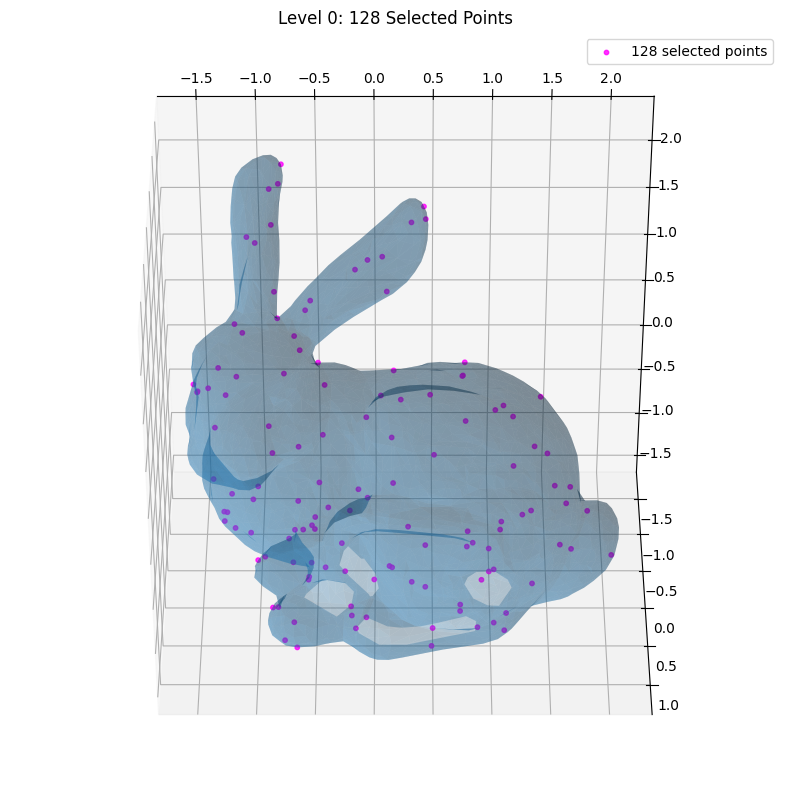

  Level 1: 512 points (nested)


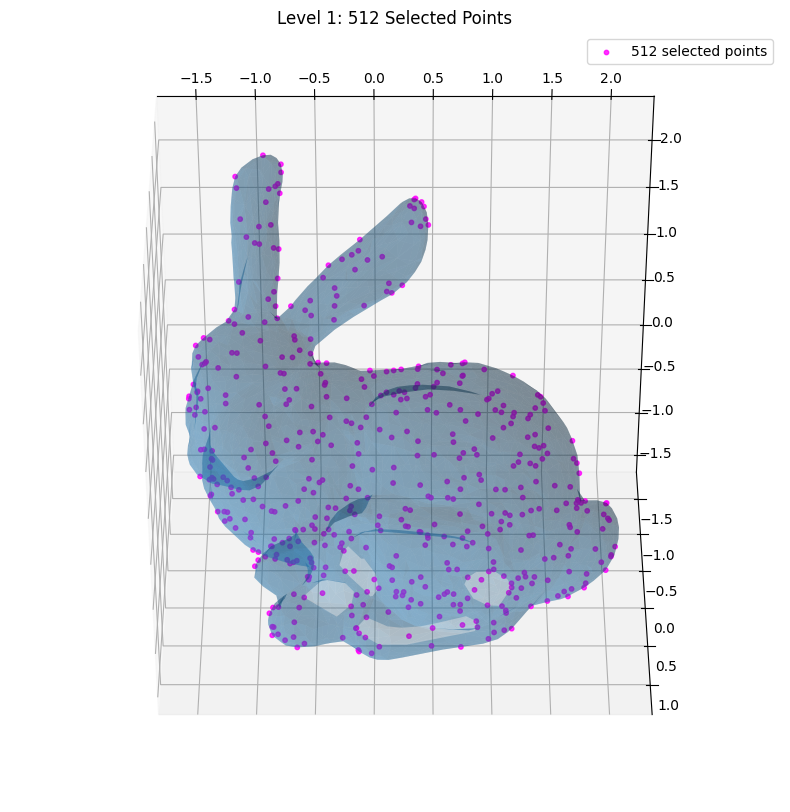

  Level 2: 1024 points (nested)


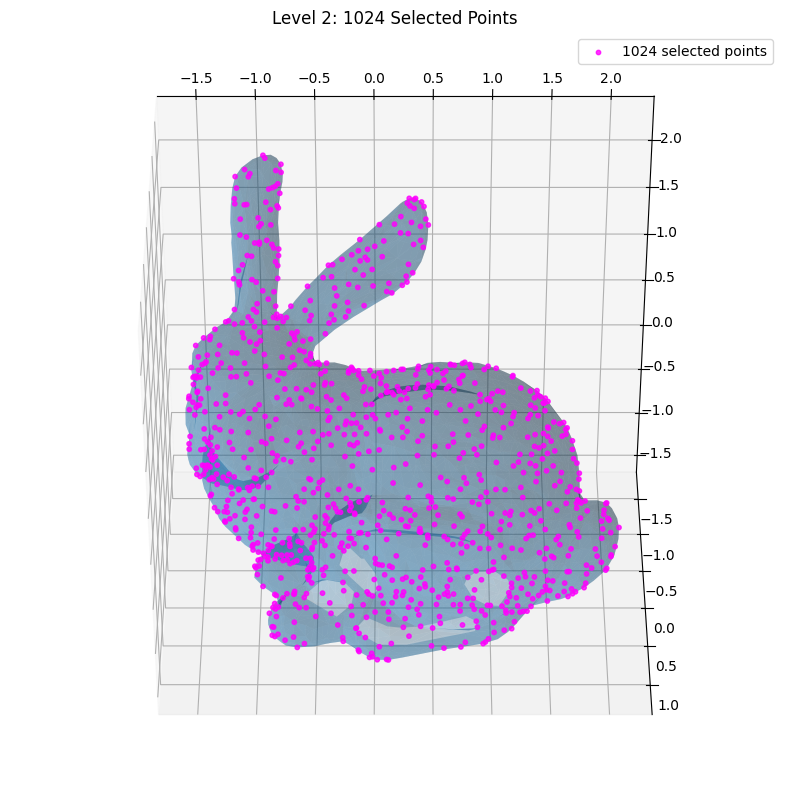

  Level 3: 2503 points (nested)


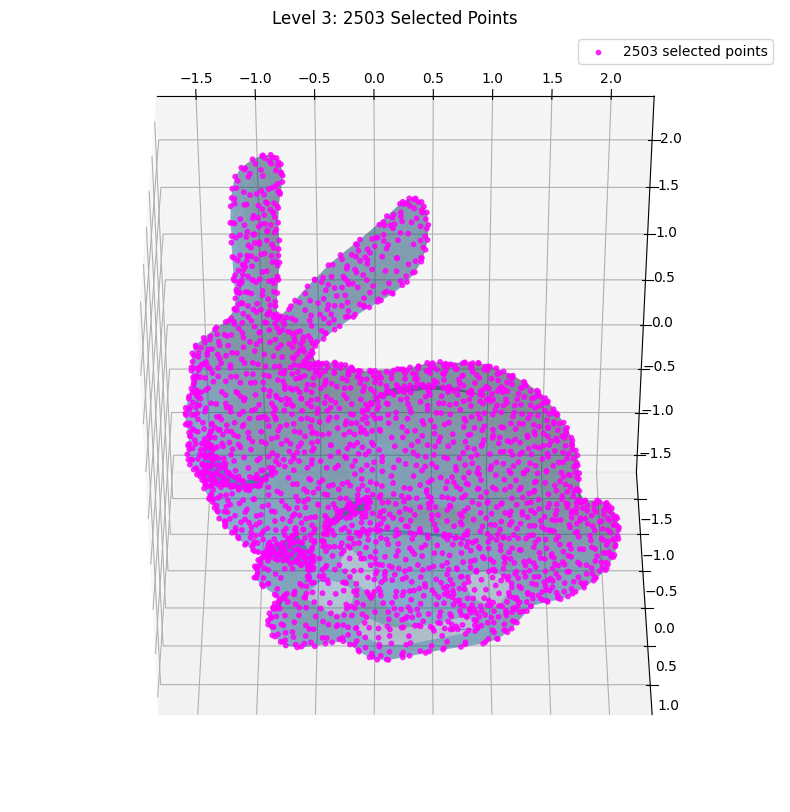



LEVEL 0: exact solve on 128 points...
Coarse eigenvalues: [0.       0.464393 0.860068 1.196359 1.413617 1.861207 2.273839 2.759782
 2.87012  3.25778 ]

Training physics-informed multiresolution GNN...
Epoch    0: Loss=0.554642
Epoch  100: Loss=0.387595
Epoch  200: Loss=0.239750
Epoch  300: Loss=0.114375
Epoch  400: Loss=0.053133
Epoch  500: Loss=0.036650
Epoch  600: Loss=0.027105
Epoch  700: Loss=0.022693
Epoch  800: Loss=0.019977
Epoch  900: Loss=0.018173
Epoch 1000: Loss=0.016806
Epoch 1100: Loss=0.015731
Epoch 1200: Loss=0.014839
Epoch 1300: Loss=0.014090
Epoch 1400: Loss=0.013441
Epoch 1500: Loss=0.012875
Epoch 1600: Loss=0.012405
Epoch 1700: Loss=0.011942
Epoch 1800: Loss=0.011538
Epoch 1900: Loss=0.011163
Epoch 1999: Loss=0.010846
Level 0 refined eigenvalues: [0.    0.47  0.866 1.202 1.422 1.87  2.303 2.783 2.889 3.441]
Level 1 refined eigenvalues: [0.    0.422 0.904 1.245 1.389 1.863 1.996 2.851 3.102 3.696]
Level 2 refined eigenvalues: [0.    0.412 0.934 1.093 1.245 1.4   1.9

In [8]:
U_pred = main()

In [12]:
m_out = meshio.Mesh(m.verts, cells, point_data={f'v{i}': U_pred[:, i] for i in range(1, 10)})

m_out.write('bunny_eigfuncs_pred.vtu')

In [15]:
(U_pred.T @ U_pred)

array([[75.63492   ,  0.93197215, -0.70492315, -2.8296125 ,  1.7008265 ,
         1.3681533 , -1.5088894 , -1.4905807 ,  0.7521043 ,  5.1550465 ],
       [ 0.93197215, 76.19254   ,  0.08775246,  3.4760437 , -0.11666322,
        -1.1946837 ,  0.53339446, -0.63218653,  2.7714825 , -4.0504284 ],
       [-0.70492315,  0.08775246, 78.215866  ,  6.9270997 , -0.2543047 ,
         0.6140865 ,  2.6032743 ,  0.40574914, -0.96837354,  0.65953624],
       [-2.8296125 ,  3.4760437 ,  6.9270997 , 74.15387   ,  0.5295537 ,
        -5.2154207 , -1.9413388 , -2.926257  , -0.8617369 ,  2.6905181 ],
       [ 1.7008265 , -0.11666322, -0.2543047 ,  0.5295537 , 80.34827   ,
        -1.6521366 , -0.7386605 ,  1.439559  , -1.0845797 , -0.50586957],
       [ 1.3681533 , -1.1946837 ,  0.6140865 , -5.2154207 , -1.6521366 ,
        75.78357   , -2.4214127 , -0.6794947 ,  0.635756  , -2.2256455 ],
       [-1.5088894 ,  0.53339446,  2.6032743 , -1.9413388 , -0.7386605 ,
        -2.4214127 , 87.18459   , -3.691384  